# Geothermal and Machine Learning Sandbox

## this notebook is simply a demonstration for trying various preprocessing techniques and plotting the results

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import random

from scipy.stats import uniform

import datetime
import time

from pathlib import Path
import os, sys

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## import local function for preprocessing PFA data

In [25]:
myPath = os.getcwd()
sys.path.append(myPath)

import PFA_preprocessing as pfa

In [26]:
myPath

'/home/srbrown/Desktop/UNR/Ingeneous_ML_Sandbox/Essentials/Geothermal_ML_git_archive/modules/data_preprocessing'

## load PFA data

In [27]:
dataPath = myPath+'/../../datasets/pandas_dataframes/'

In [28]:
dataPath

'/home/srbrown/Desktop/UNR/Ingeneous_ML_Sandbox/Essentials/Geothermal_ML_git_archive/modules/data_preprocessing/../../datasets/pandas_dataframes/'

In [29]:
filename = 'PFA_dataframe_grid_march2021_df.h5'

df_features = pd.read_hdf(dataPath+filename, 'df_features')

In [30]:
filename = 'PFA_structuralSettingsLookup_march2021_df.h5'

df_SSlookup = pd.read_hdf(dataPath+filename, 'df_SSLookup')

In [31]:
df_features.tail()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,...,GeodeticStrainRate_Error,QuaternarySlipRate_Error,FaultRecency_Error,Earthquakes_Error,Heatflow_Error,HorizGravityGradient2_Confidence,HorizMagneticGradient2_Confidence,Hillshade-100m,DEM-30m,Fairway
1727995,999.0,1723.0,R1000C1724,717077.690182,4.508464e+06,nullValue,12,12,12,14,...,0.537311,0.788923,0.403113,0.453099,22.451099,0.190986,4,180,1703,-9999.0
1727996,999.0,1724.0,R1000C1725,717327.690182,4.508464e+06,nullValue,12,12,12,14,...,0.536572,0.788923,0.403113,0.468096,22.432301,0.203718,4,180,1705,-9999.0
1727997,999.0,1725.0,R1000C1726,717577.690182,4.508464e+06,nullValue,12,12,12,14,...,0.535831,0.788923,0.403113,0.468096,22.413500,0.190986,4,180,1703,-9999.0
1727998,999.0,1726.0,R1000C1727,717827.690182,4.508464e+06,nullValue,12,12,12,14,...,0.535089,0.788923,0.403113,0.468096,22.394600,0.165521,4,180,1702,-9999.0
1727999,999.0,1727.0,R1000C1728,718077.690182,4.508464e+06,nullValue,12,12,12,14,...,0.534346,0.788923,0.403113,0.468096,22.375601,0.165521,4,180,1702,-9999.0


## preprocess data

In [32]:
extraFeatures = ['GeochemistryTemperature2', 
                 'TufaOrTravertine_Distance',
                 'Silica_Distance',
                 'Hillshade-100m', 'DEM-30m']
# extraFeatures = ['HorizMagneticGradient2','DEM-30m']
# extraFeatures = None

In [33]:
dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_LocalNumerical(df_features, 
                                                                          resetLocal=None,
                                                                          transformFaultTraces='distance_edt',
                                                                          extraFeatures=extraFeatures, 
                                                                          prescaleFeatures=False)

dfc, dfInfoc, nullIndexesc, scalerc = pfa.preprocess_features_LocalCategorical(df_features.copy(), df_SSlookup,
                                                                               resetLocal=None,
                                                                               transformFaultTraces='distance_edt',
                                                                               extraFeatures=None,
                                                                               prescaleFeatures=True)

# transformDict = {}
transformDict = {'features': ['Local-StructuralSetting', 'QuaternaryFaultTraces'], 
                 'transforms': ['gaussianFilter', 'gaussianFilter'], 
                 'params': [5, 10]}

dfna, dfInfo, nullIndexes, scaler = pfa.preprocess_features_AllNumerical(df_features,
                                                                          transformFeatures=transformDict,
                                                                          extraFeatures=extraFeatures, 
                                                                          prescaleFeatures=False, withMean=False)
                                                                          # prescaleFeatures=False, withMean=True)




/home/srbrown/mambaforge/envs/pytorchGeo/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
dfna.columns

Index(['Local-StructuralSetting', 'Local-QuaternaryFaultRecency',
       'Local-QuaternaryFaultSlipDilation', 'Local-QuaternaryFaultSlipRate',
       'QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'GeochemistryTemperature2', 'TufaOrTravertine_Distance',
       'Silica_Distance', 'Hillshade-100m', 'DEM-30m'],
      dtype='object')

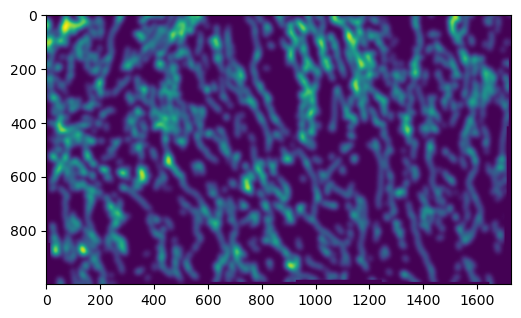

In [35]:
fig, ax = plt.subplots(figsize=(6,4))

x = dfna['QuaternaryFaultTraces'].to_numpy()
x = np.reshape(x,(1000,-1))
plt.imshow(x)

Text(0.5, 1.0, 'raw')

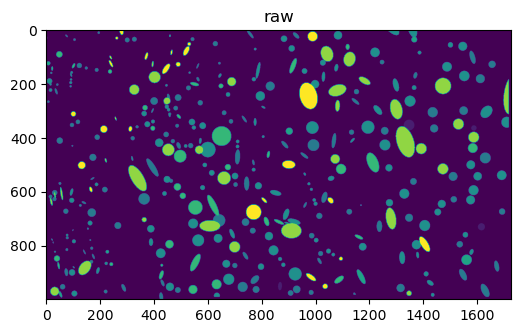

In [36]:
fig, ax = plt.subplots(figsize=(6,4))

x = dfn['Local-StructuralSetting'].to_numpy()
x = np.reshape(x,(1000,-1))
plt.imshow(x)
plt.title('raw')

Text(0.5, 1.0, 'row 200, sigma=5')

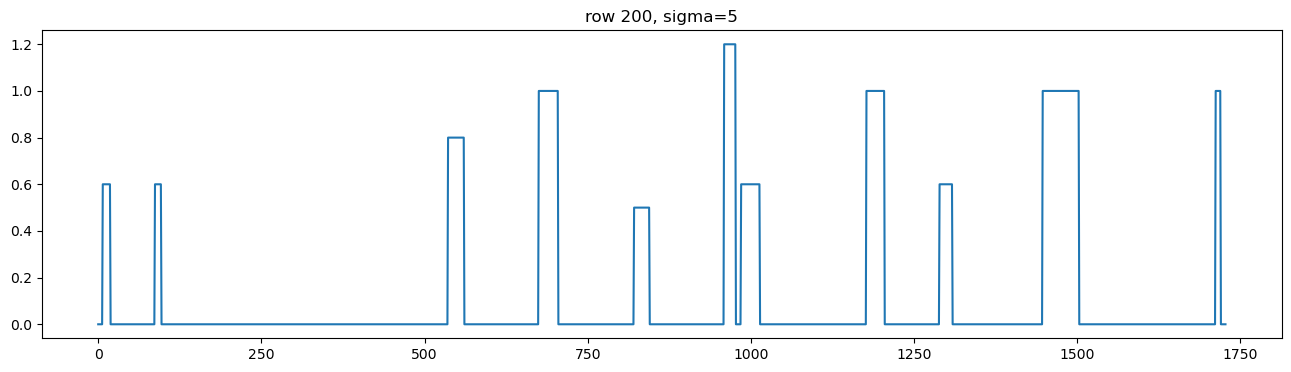

In [37]:
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(x[200,:])

plt.title('row 200, sigma=5')
# plt.savefig('profileSigma5.png')

### in preprocessing we could transform the target to account for a skewed distribution

In [38]:
x = dfna['HorizMagneticGradient2'].to_numpy()

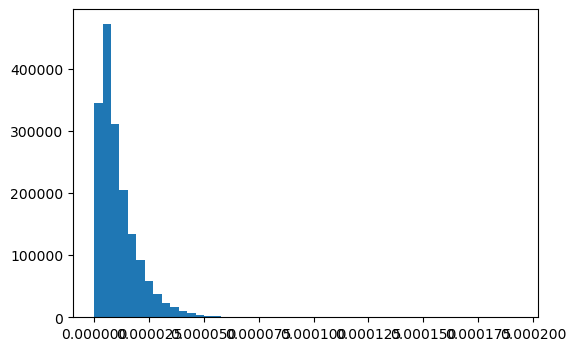

In [39]:
fig, ax = plt.subplots(figsize=(6,4))

plt.hist(x,50);

In [40]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(standardize=True)

transformed = pt.fit_transform(x.reshape(-1,1))
y = transformed

print(pt.lambdas_)

[-67588.33732235]


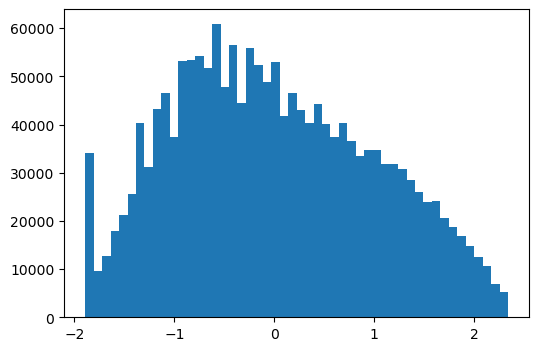

In [41]:
fig, ax = plt.subplots(figsize=(6,4))

plt.hist(y,50);

### we can inverse transform (back) the data

In [42]:
yInverse = pt.inverse_transform(y.reshape(-1,1))

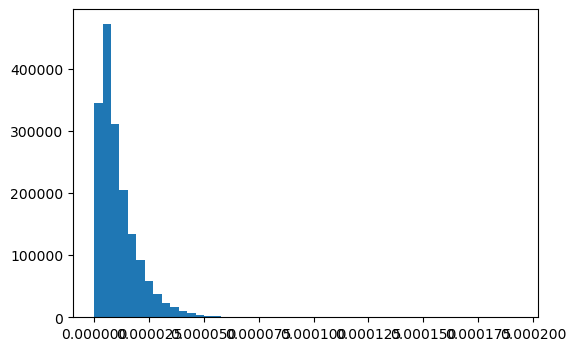

In [43]:
fig, ax = plt.subplots(figsize=(6,4))

plt.hist(yInverse,50);

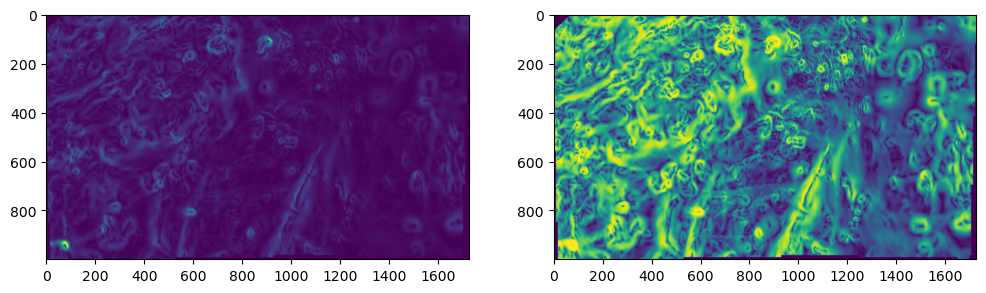

In [44]:
fig, ax = plt.subplots(figsize=(12,4), nrows=1, ncols=2)

x = np.reshape(x,(1000,-1))
y = np.reshape(y,(1000,-1))

ax[0].imshow(x)
ax[1].imshow(y)